<a href="https://colab.research.google.com/github/Pkodeboy/64061_AML/blob/main/Assignment%203/Assignment_3_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deep learning for timeseries**


In [1]:
# Download the jena_climate_2009_2016.csv.zip file from AWS S3
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

# Unzip the jena_climate_2009_2016.csv.zip file
!unzip jena_climate_2009_2016.csv.zip


--2023-11-07 02:45:02--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.16.134, 52.217.134.8, 52.217.100.158, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.16.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  20.4MB/s    in 0.6s    

2023-11-07 02:45:03 (20.4 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Importing the data file**

In [2]:
#Importing csv
import os
fname = os.path.join("jena_climate_2009_2016.csv")

In [3]:
#Reading Data from file
with open(fname) as f:
    data = f.read()

In [4]:
# Split the data into lines
lines = data.split("\n")
# Get the header row
header = lines[0].split(",")
# Remove the header row from the list of lines
lines = lines[1:]
# Print the header row
print(header)
# Print the number of lines in the data
print(len(lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [5]:
import numpy as np

# Create a NumPy array to store the temperature data
temperature = np.zeros((len(lines),))

# Create a NumPy array to store the raw data
raw_data = np.zeros((len(lines), len(header) - 1))

# Iterate over the lines in the data
for i, line in enumerate(lines):

    # Split the line into a list of values
    values = [float(x) for x in line.split(",")[1:]]

    # Store the temperature in the temperature array
    temperature[i] = values[1]

    # Store the raw data in the raw_data array
    raw_data[i, :] = values[:]


**Plotting the temperature timeseries**

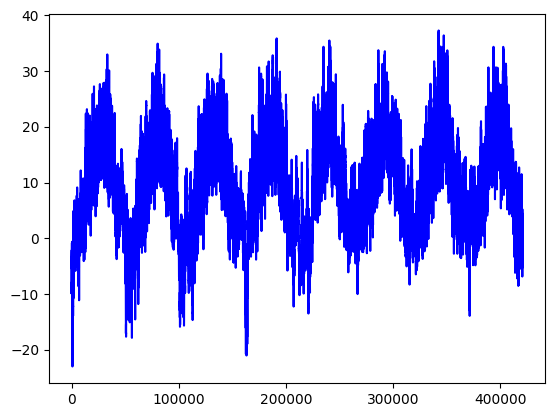

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(len(temperature)), temperature, color='blue')



**Plotting the first 15 days of the temperature timeseries**

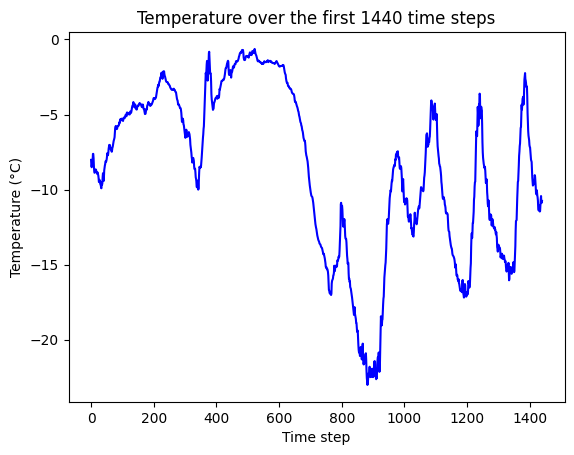

In [7]:
## Plot the first 1440 temperature values
plt.plot(range(1440), temperature[:1440], color='blue')
# Set the x-axis label
plt.xlabel("Time step")

# Set the y-axis label
plt.ylabel("Temperature (°C)")

# Set the title of the plot
plt.title("Temperature over the first 1440 time steps")

# Display the plot
plt.show()


**Computing the number of samples we'll use for each data split**

In [8]:
# Split the data into train, validation, and test sets
num_train_samples = int(0.5 * len(raw_data))  # 50% of the data for training
num_val_samples = int(0.25 * len(raw_data))  # 25% of the data for validation
num_test_samples = len(raw_data) - num_train_samples - num_val_samples  # The remaining 25% of the data for testing


**Preparing the data
Normalizing the data**

In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [10]:
#Instantiating datasets for training, validation, and testing
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

In [11]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],  # The input data
    targets=temperature[delay:],  # The target data
    sampling_rate=sampling_rate,  # The sampling rate
    sequence_length=sequence_length,  # The length of the sequences
    shuffle=True,  # Whether to shuffle the data
    batch_size=batch_size,  # The batch size
    start_index=0,  # The start index
    end_index=num_train_samples)  # The end index


In [12]:
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],  # The input data
    targets=temperature[delay:],  # The target data
    sampling_rate=sampling_rate,  # The sampling rate
    sequence_length=sequence_length,  # The length of the sequences
    shuffle=True,  # Whether to shuffle the data
    batch_size=batch_size,  # The batch size
    start_index=num_train_samples,  # The start index
    end_index=num_train_samples + num_val_samples)  # The end index


In [13]:
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],  # The input data
    targets=temperature[delay:],  # The target data
    sampling_rate=sampling_rate,  # The sampling rate
    sequence_length=sequence_length,  # The length of the sequences
    shuffle=True,  # Whether to shuffle the data
    batch_size=batch_size,  # The batch size
    start_index=num_train_samples + num_val_samples,  # The start index
    # Set the end index to None so that the dataset will contain all of the remaining samples.
    end_index=None)


In [14]:
# Iterate over the first sample in the train dataset
for samples, targets in train_dataset:
    # Print the shape of the samples and targets
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)

    # Break out of the loop after the first iteration
    break


samples shape: (256, 120, 14)
targets shape: (256,)


In [15]:
#A common-sense, non-machine-learning baseline
#Computing the common-sense baseline MAE
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [16]:
from tensorflow import keras
from keras import layers

In [17]:
#Training and evaluating a densely connected model
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 19s 17ms/step - loss: 13.4820 - mae: 2.8290 - val_loss: 11.3724 - val_mae: 2.6871
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 9.2694 - mae: 2.3964 - val_loss: 11.6038 - val_mae: 2.7122
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 8.5695 - mae: 2.3068 - val_loss: 11.2893 - val_mae: 2.6801
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 8.1008 - mae: 2.2418 - val_loss: 11.2267 - val_mae: 2.6588
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 7.7666 - mae: 2.1957 - val_loss: 11.8042 - val_mae: 2.7277
Epoch 6/10
819/819 [==============================] - 14s 16ms/step - loss: 7.5181 - mae: 2.1598 - val_loss: 11.5844 - val_mae: 2.7013
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 7.2967 - mae: 2.1292 - val_loss: 10.8855 - val_mae: 2.6351
Epoch 8/10
819/819 [==============================] - 

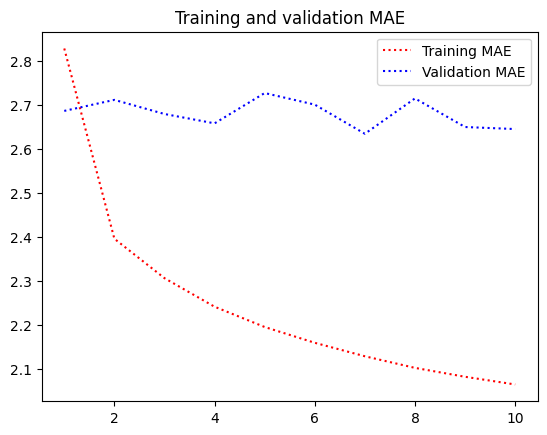

In [18]:

import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()


**1D Convolution model with 10 epoch**

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 18ms/step - loss: 23.4288 - mae: 3.7765 - val_loss: 15.7693 - val_mae: 3.1412
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 15.5515 - mae: 3.1280 - val_loss: 15.0924 - val_mae: 3.0580
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 14.2460 - mae: 2.9842 - val_loss: 15.4886 - val_mae: 3.1318
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 13.3609 - mae: 2.8843 - val_loss: 14.8175 - val_mae: 3.0311
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 12.7073 - mae: 2.8093 - val_loss: 16.2222 - val_mae: 3.1984
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 12.1893 - mae: 2.7501 - val_loss: 15.1656 - val_mae: 3.0803
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 11.7351 - mae: 2.6979 - val_loss: 16.1767 - val_mae: 3.1687
Epoch 8/10
819/819 [============================

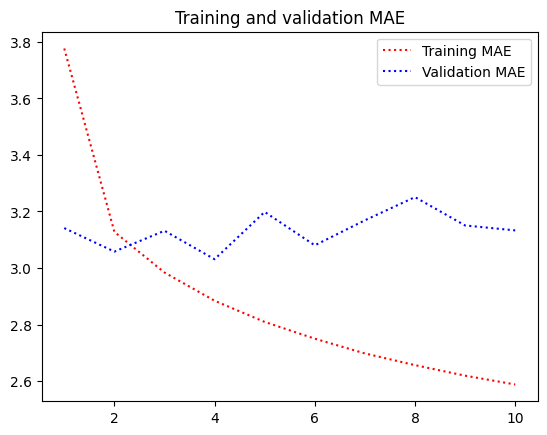

In [26]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**The training and validation losses are decreasing over time, which suggests that the model is learning.
The validation loss is slightly higher than the training loss, which is normal. It is important to monitor the validation loss to make sure that the model is not overfitting the training data.
The test MAE is somewhat higher than the validation MAE, which suggests that the model is not generalizing perfectly to unseen data. This could be due to a number of factors, such as noise in the data or the model being undertrained.**


**A Simple RNN**

In [28]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 49s 58ms/step - loss: 138.4381 - mae: 9.6668 - val_loss: 144.1101 - val_mae: 9.9165
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 136.4216 - mae: 9.5585 - val_loss: 143.6948 - val_mae: 9.8625
Epoch 3/10
819/819 [==============================] - 47s 57ms/step - loss: 136.3318 - mae: 9.5502 - val_loss: 143.6673 - val_mae: 9.8641
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 136.2501 - mae: 9.5455 - val_loss: 143.6963 - val_mae: 9.8728
Epoch 5/10
819/819 [==============================] - 47s 57ms/step - loss: 136.2037 - mae: 9.5412 - val_loss: 143.5776 - val_mae: 9.8547
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 136.2047 - mae: 9.5417 - val_loss: 143.5813 - val_mae: 9.8553
Epoch 7/10
819/819 [==============================] - 46s 57ms/step - loss: 136.1790 - mae: 9.5400 - val_loss: 143.5899 - val_mae: 9.8563
Epoch 8/10
819/819 [==============

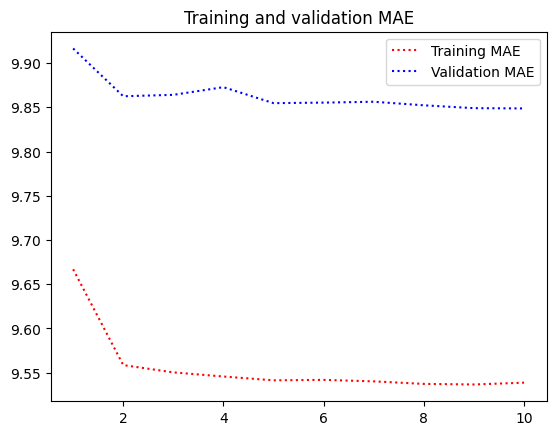

In [29]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Simple RNN - Stacking RNN layers**

In [31]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 181s 218ms/step - loss: 136.6849 - mae: 9.5591 - val_loss: 143.3931 - val_mae: 9.8355
Epoch 2/10
819/819 [==============================] - 177s 216ms/step - loss: 135.9559 - mae: 9.5132 - val_loss: 143.4474 - val_mae: 9.8419
Epoch 3/10
819/819 [==============================] - 176s 214ms/step - loss: 135.9112 - mae: 9.5075 - val_loss: 143.4152 - val_mae: 9.8381
Epoch 4/10
819/819 [==============================] - 176s 215ms/step - loss: 135.8785 - mae: 9.5039 - val_loss: 143.4231 - val_mae: 9.8403
Epoch 5/10
819/819 [==============================] - 175s 214ms/step - loss: 135.8554 - mae: 9.5007 - val_loss: 143.4433 - val_mae: 9.8436
Epoch 6/10
819/819 [==============================] - 177s 216ms/step - loss: 135.8393 - mae: 9.4981 - val_loss: 143.4384 - val_mae: 9.8416
Epoch 7/10
819/819 [==============================] - 177s 216ms/step - loss: 135.8253 - mae: 9.4967 - val_loss: 143.4332 - val_mae: 9.8386
Epoch 8/10
819/819 [

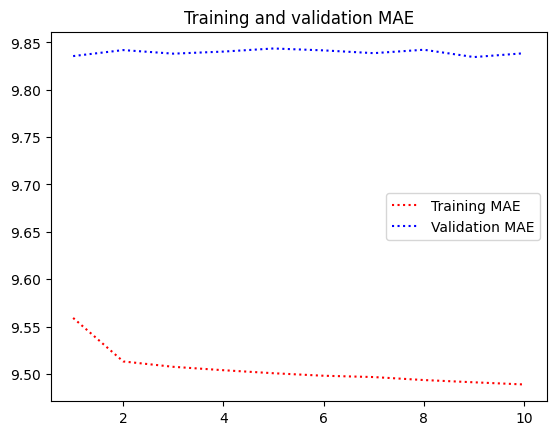

In [32]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Simple GRU (Gated Recurrent Unit)**

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 19s 20ms/step - loss: 44.2889 - mae: 4.8243 - val_loss: 13.2242 - val_mae: 2.7194
Epoch 2/10
819/819 [==============================] - 17s 21ms/step - loss: 10.7216 - mae: 2.5449 - val_loss: 9.6519 - val_mae: 2.3862
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 9.4775 - mae: 2.4042 - val_loss: 9.9991 - val_mae: 2.4041
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 9.1699 - mae: 2.3630 - val_loss: 10.1835 - val_mae: 2.4251
Epoch 5/10
819/819 [==============================] - 16s 20ms/step - loss: 8.9668 - mae: 2.3368 - val_loss: 9.6481 - val_mae: 2.3947
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 8.7911 - mae: 2.3151 - val_loss: 10.4191 - val_mae: 2.4625
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 8.6311 - mae: 2.2954 - val_loss: 9.8421 - val_mae: 2.4117
Epoch 8/10
819/819 [==============================] - 14s

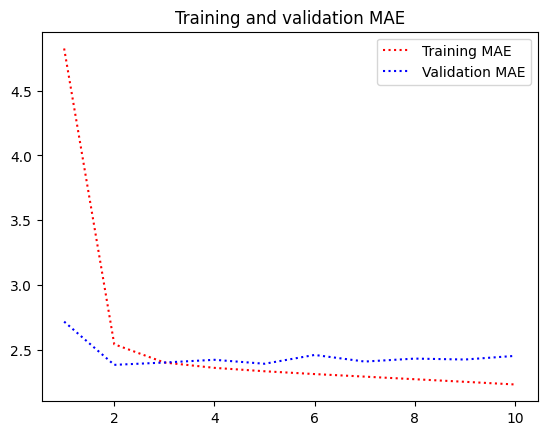

In [34]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**LSTM-Simple is a simplified version of the Long Short-Term Memory (LSTM) network architecture**

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 19s 21ms/step - loss: 42.1768 - mae: 4.7223 - val_loss: 12.8490 - val_mae: 2.7225
Epoch 2/10
819/819 [==============================] - 17s 20ms/step - loss: 11.0839 - mae: 2.5847 - val_loss: 9.8680 - val_mae: 2.4432
Epoch 3/10
819/819 [==============================] - 17s 20ms/step - loss: 9.8862 - mae: 2.4512 - val_loss: 9.6550 - val_mae: 2.4077
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 9.5369 - mae: 2.4038 - val_loss: 9.8043 - val_mae: 2.4166
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 9.1669 - mae: 2.3561 - val_loss: 9.9850 - val_mae: 2.4297
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 8.8621 - mae: 2.3152 - val_loss: 9.8065 - val_mae: 2.4134
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 8.6407 - mae: 2.2852 - val_loss: 10.2751 - val_mae: 2.4736
Epoch 8/10
819/819 [==============================] - 14s 

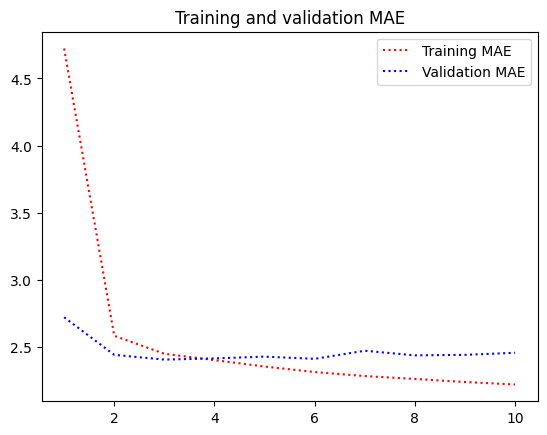

In [36]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**LSTM (RNN) - dropout Regularization that is widely used for tasks involving sequential data, such as natural language processing and time series analysis. LSTM networks are designed to capture long-term dependencies in data**

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 260s 312ms/step - loss: 46.3123 - mae: 5.0583 - val_loss: 12.9376 - val_mae: 2.7216
Epoch 2/10
819/819 [==============================] - 256s 313ms/step - loss: 19.8572 - mae: 3.4218 - val_loss: 9.6878 - val_mae: 2.4237
Epoch 3/10
819/819 [==============================] - 256s 312ms/step - loss: 18.1382 - mae: 3.2749 - val_loss: 9.5697 - val_mae: 2.4151
Epoch 4/10
819/819 [==============================] - 255s 311ms/step - loss: 17.2252 - mae: 3.1898 - val_loss: 9.6800 - val_mae: 2.4321
Epoch 5/10
819/819 [==============================] - 254s 310ms/step - loss: 16.5955 - mae: 3.1352 - val_loss: 9.3134 - val_mae: 2.3830
Epoch 6/10
819/819 [==============================] - 258s 315ms/step - loss: 16.1308 - mae: 3.0910 - val_loss: 9.2411 - val_mae: 2.3748
Epoch 7/10
819/819 [==============================] - 260s 317ms/step - loss: 15.8244 - mae: 3.0659 - val_loss: 9.2205 - val_mae: 2.3709
Epoch 8/10
819/819 [====================

405/405 [==============================] - 16s 39ms/step - loss: 10.3174 - mae: 2.5142
Test MAE: 2.51


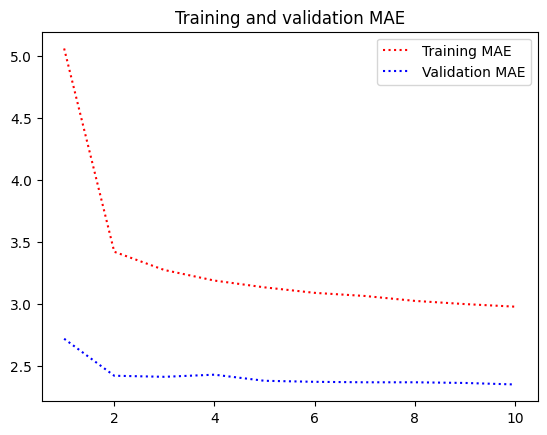

In [38]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Stacked LSTM setup involves using multiple LSTM layers stacked on top of each other in a neural network. Each LSTM layer captures different levels of abstraction in the input data, allowing for more powerful modeling of sequential information.**

**8 UNITS**

In [39]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 26s 28ms/step - loss: 76.8934 - mae: 6.7831 - val_loss: 40.7528 - val_mae: 4.7969
Epoch 2/10
819/819 [==============================] - 22s 26ms/step - loss: 24.2807 - mae: 3.6407 - val_loss: 14.2707 - val_mae: 2.8325
Epoch 3/10
819/819 [==============================] - 23s 27ms/step - loss: 11.7765 - mae: 2.6387 - val_loss: 10.1947 - val_mae: 2.4753
Epoch 4/10
819/819 [==============================] - 22s 26ms/step - loss: 9.9413 - mae: 2.4548 - val_loss: 10.1739 - val_mae: 2.4787
Epoch 5/10
819/819 [==============================] - 22s 27ms/step - loss: 9.4259 - mae: 2.3937 - val_loss: 9.7329 - val_mae: 2.4161
Epoch 6/10
819/819 [==============================] - 17s 20ms/step - loss: 9.1349 - mae: 2.3621 - val_loss: 9.9111 - val_mae: 2.4485
Epoch 7/10
819/819 [==============================] - 22s 26ms/step - loss: 8.8899 - mae: 2.3317 - val_loss: 9.7146 - val_mae: 2.4270
Epoch 8/10
819/819 [==============================] - 1

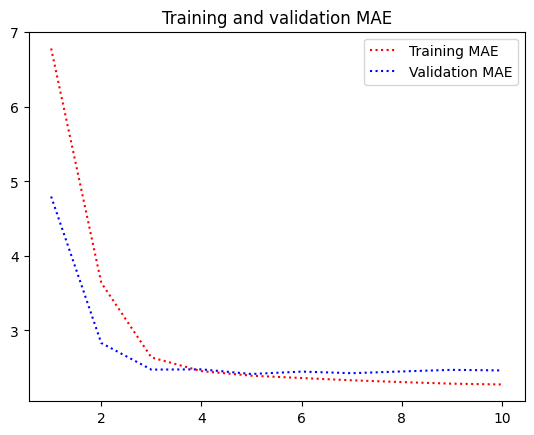

In [40]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**16 UNITS**

In [42]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 26s 28ms/step - loss: 43.0650 - mae: 4.8063 - val_loss: 13.6166 - val_mae: 2.8098
Epoch 2/10
819/819 [==============================] - 22s 27ms/step - loss: 10.8120 - mae: 2.5549 - val_loss: 9.8406 - val_mae: 2.4374
Epoch 3/10
819/819 [==============================] - 23s 28ms/step - loss: 9.2154 - mae: 2.3653 - val_loss: 9.8247 - val_mae: 2.4500
Epoch 4/10
819/819 [==============================] - 17s 21ms/step - loss: 8.5431 - mae: 2.2741 - val_loss: 10.0183 - val_mae: 2.4604
Epoch 5/10
819/819 [==============================] - 17s 21ms/step - loss: 7.9641 - mae: 2.1929 - val_loss: 10.0558 - val_mae: 2.4647
Epoch 6/10
819/819 [==============================] - 17s 20ms/step - loss: 7.3822 - mae: 2.1155 - val_loss: 10.2990 - val_mae: 2.4939
Epoch 7/10
819/819 [==============================] - 17s 20ms/step - loss: 6.9272 - mae: 2.0490 - val_loss: 10.6278 - val_mae: 2.5349
Epoch 8/10
819/819 [==============================] - 1

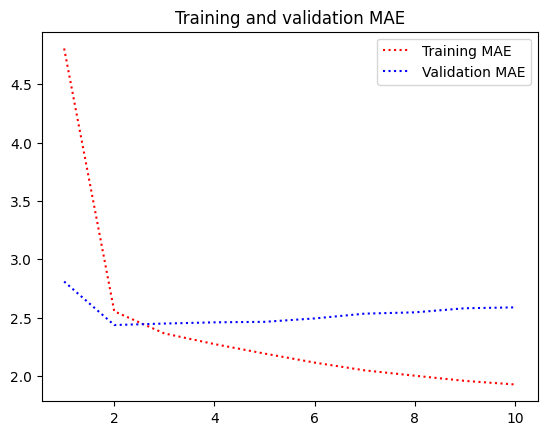

In [43]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**32 UNITS**

In [44]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 27s 29ms/step - loss: 22.1696 - mae: 3.3588 - val_loss: 11.0304 - val_mae: 2.5784
Epoch 2/10
819/819 [==============================] - 17s 20ms/step - loss: 7.6973 - mae: 2.1602 - val_loss: 11.5378 - val_mae: 2.6655
Epoch 3/10
819/819 [==============================] - 17s 20ms/step - loss: 6.1526 - mae: 1.9194 - val_loss: 12.6568 - val_mae: 2.7874
Epoch 4/10
819/819 [==============================] - 17s 20ms/step - loss: 5.1965 - mae: 1.7608 - val_loss: 12.7817 - val_mae: 2.8204
Epoch 5/10
819/819 [==============================] - 17s 20ms/step - loss: 4.4673 - mae: 1.6284 - val_loss: 15.0836 - val_mae: 3.0509
Epoch 6/10
819/819 [==============================] - 17s 20ms/step - loss: 3.9577 - mae: 1.5253 - val_loss: 14.4722 - val_mae: 2.9897
Epoch 7/10
819/819 [==============================] - 17s 20ms/step - loss: 3.5458 - mae: 1.4423 - val_loss: 14.1674 - val_mae: 2.9677
Epoch 8/10
819/819 [==============================] - 

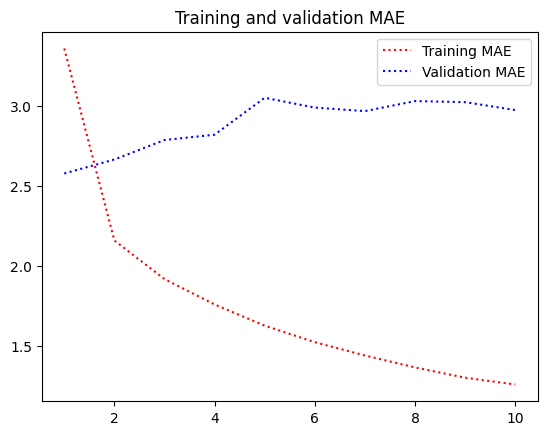

In [45]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**64 UNITS**

In [46]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked4.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked4.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 27s 30ms/step - loss: 12.6671 - mae: 2.6405 - val_loss: 10.4024 - val_mae: 2.5487
Epoch 2/10
819/819 [==============================] - 17s 21ms/step - loss: 5.0097 - mae: 1.7242 - val_loss: 12.2122 - val_mae: 2.7846
Epoch 3/10
819/819 [==============================] - 18s 21ms/step - loss: 2.9085 - mae: 1.3057 - val_loss: 13.4663 - val_mae: 2.8976
Epoch 4/10
819/819 [==============================] - 18s 21ms/step - loss: 2.0262 - mae: 1.0863 - val_loss: 13.0267 - val_mae: 2.8398
Epoch 5/10
819/819 [==============================] - 17s 21ms/step - loss: 1.5629 - mae: 0.9500 - val_loss: 13.3964 - val_mae: 2.8938
Epoch 6/10
819/819 [==============================] - 17s 21ms/step - loss: 1.2534 - mae: 0.8495 - val_loss: 13.7155 - val_mae: 2.9274
Epoch 7/10
819/819 [==============================] - 17s 21ms/step - loss: 1.0876 - mae: 0.7852 - val_loss: 13.5907 - val_mae: 2.9153
Epoch 8/10
819/819 [==============================] - 

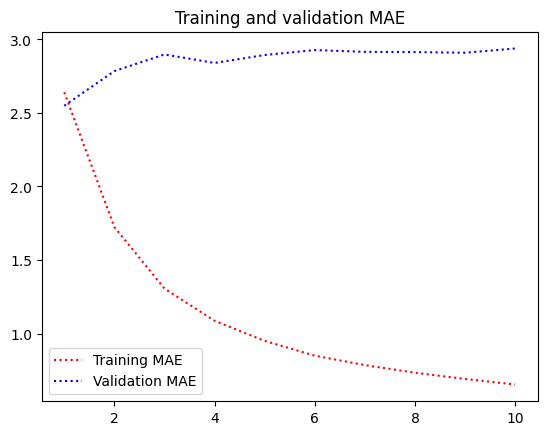

In [47]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**LSTM - dropout-regularized, stacked model**

In [48]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 538s 652ms/step - loss: 70.8300 - mae: 6.4436 - val_loss: 35.0430 - val_mae: 4.3715
Epoch 2/10
819/819 [==============================] - 529s 646ms/step - loss: 32.1669 - mae: 4.2365 - val_loss: 13.3818 - val_mae: 2.7223
Epoch 3/10
819/819 [==============================] - 540s 659ms/step - loss: 24.6043 - mae: 3.7576 - val_loss: 10.5627 - val_mae: 2.4776
Epoch 4/10
819/819 [==============================] - 537s 655ms/step - loss: 22.5156 - mae: 3.5952 - val_loss: 10.0986 - val_mae: 2.4408
Epoch 5/10
819/819 [==============================] - 527s 644ms/step - loss: 21.1766 - mae: 3.4906 - val_loss: 9.5768 - val_mae: 2.3858
Epoch 6/10
819/819 [==============================] - 524s 639ms/step - loss: 20.1218 - mae: 3.4064 - val_loss: 9.4267 - val_mae: 2.3698
Epoch 7/10
819/819 [==============================] - 530s 647ms/step - loss: 19.3057 - mae: 3.3370 - val_loss: 9.4758 - val_mae: 2.3821
Epoch 8/10
819/819 [=================

405/405 [==============================] - 29s 70ms/step - loss: 10.5393 - mae: 2.5416
Test MAE: 2.54


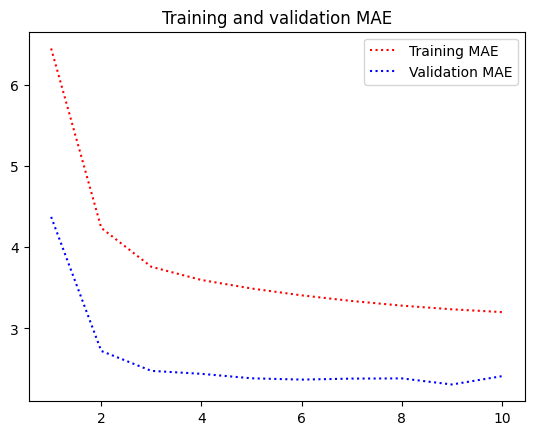

In [49]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Bi Directional LSTM**

In [50]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.st",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 29s 32ms/step - loss: 24.7005 - mae: 3.5851 - val_loss: 10.6722 - val_mae: 2.5303
Epoch 2/10
819/819 [==============================] - 26s 31ms/step - loss: 9.4832 - mae: 2.4015 - val_loss: 9.5475 - val_mae: 2.4071
Epoch 3/10
819/819 [==============================] - 16s 20ms/step - loss: 8.5567 - mae: 2.2820 - val_loss: 9.7748 - val_mae: 2.4444
Epoch 4/10
819/819 [==============================] - 16s 20ms/step - loss: 8.0065 - mae: 2.2093 - val_loss: 10.0253 - val_mae: 2.4710
Epoch 5/10
819/819 [==============================] - 16s 19ms/step - loss: 7.5797 - mae: 2.1536 - val_loss: 9.7985 - val_mae: 2.4441
Epoch 6/10
819/819 [==============================] - 16s 20ms/step - loss: 7.2339 - mae: 2.1016 - val_loss: 10.7006 - val_mae: 2.5421
Epoch 7/10
819/819 [==============================] - 16s 20ms/step - loss: 6.9506 - mae: 2.0596 - val_loss: 10.4115 - val_mae: 2.5082
Epoch 8/10
819/819 [==============================] - 16s

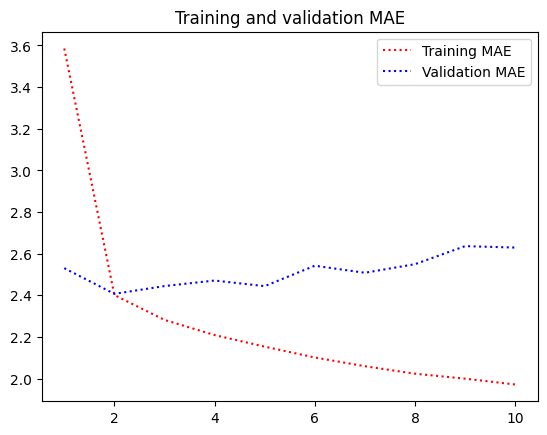

In [51]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**1D Convnets and LSTM togther**

In [52]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.st", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 19s 21ms/step - loss: 50.0698 - mae: 5.2951 - val_loss: 27.9118 - val_mae: 4.1339
Epoch 2/10
819/819 [==============================] - 18s 22ms/step - loss: 18.0295 - mae: 3.2657 - val_loss: 21.7121 - val_mae: 3.6979
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 14.7811 - mae: 2.9728 - val_loss: 22.3197 - val_mae: 3.7212
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 13.0615 - mae: 2.7884 - val_loss: 27.4163 - val_mae: 4.0884
Epoch 5/10
819/819 [==============================] - 14s 16ms/step - loss: 11.9344 - mae: 2.6590 - val_loss: 22.5451 - val_mae: 3.7690
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 11.0296 - mae: 2.5493 - val_loss: 22.2988 - val_mae: 3.7842
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 10.3041 - mae: 2.4591 - val_loss: 23.2600 - val_mae: 3.8458
Epoch 8/10
819/819 [============================

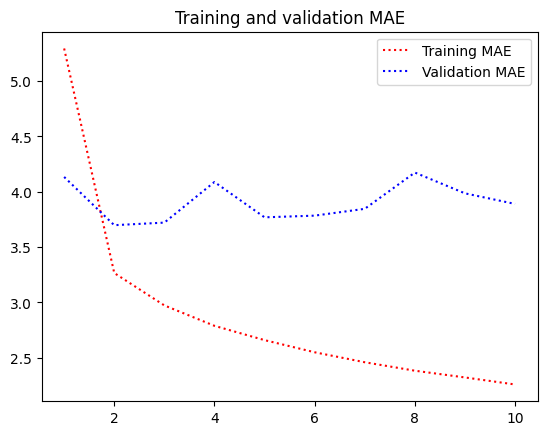

In [53]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()


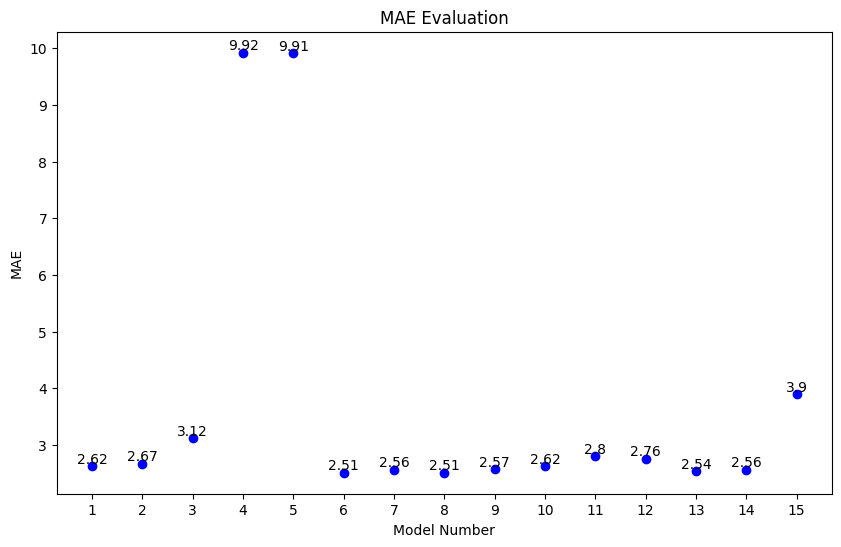

In [55]:
import matplotlib.pyplot as plt
import numpy as np

Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14","15")
Mae = (2.62,2.67,3.12,9.92,9.91,2.51,2.56,2.51,2.57,2.62,2.80,2.76,2.54,2.56,3.90)

# MAE Evaluation
plt.figure(figsize=(10, 6))
plt.scatter(Models, Mae, color="blue")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()
